# Принятие решений в бизнесе на основе данных

## Содержание

1. [Задание](#task)
1. [Описание данных](#data_description)
1. [Импорт библиотек и общая предустановка](#import)
1. [Общее изучение данных](#first_look)
1. [Подготовка данных](#etl)
1. [Приоритизация гипотез](#hypotheses)
1. [Обработка результатов A/B-теста](#test_results_preparation)
1. [Анализ A/B-теста](#test_results_analysis)
1. [Расчет статистической значимости](#stat)
1. [Решение по результатам теста](#conclusion)

## Задание
<a id = "task"></a>

__Необходимо для увеличения выручку интернет-магазина:__
- приоритизировать гипотезы,
- запустить A/B-тест,
- проанализировать результаты.

## Описание данных
<a id = "data_description"></a>

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Таблица __hypothesis__
- Hypothesis — краткое описание гипотезы
- Reach — охват пользователей по 10-балльной шкале
- Impact — влияние на пользователей по 10-балльной шкале
- Confidence — уверенность в гипотезе по 10-балльной шкале
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы

Таблица __orders__
- transactionId — идентификатор заказа
- visitorId — идентификатор пользователя, совершившего заказ
- date — дата, когда был совершён заказ
- revenue — выручка заказа
- group — группа A/B-теста, в которую попал заказ

Таблица __visitors__
- date — дата
- group — группа A/B-теста
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Импорт библиотек и глобальная предустановка
<a id = "import"></a>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import datetime as dt
import math as mth

import seaborn as sns
sns.set(style="whitegrid")

import warnings

import matplotlib.pyplot as plt

%matplotlib inline

# отключение предупреждений Anaconda
warnings.simplefilter('ignore')

from pylab import rcParams

# размер графиков по умолчанию
rcParams['figure.figsize'] = 16, 8

title_font = {'size':'16', 'color':'black', 'weight':'bold',
              'verticalalignment':'bottom'}

axis_font = {'size':'14', 'weight':'bold'}

# отображение одного знака после запятой
pd.options.display.float_format = '{:,.1f}'.format

## Общее изучение данных
<a id = "first_look"></a>

In [3]:
hypothesis = pd.read_csv('hypothesis.csv')

In [4]:
orders = pd.read_csv('orders.csv')

In [5]:
visitors = pd.read_csv('visitors.csv')

In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


- В таблице __hypothesis__ пропусков нет. 
- Необходимо привести заголовки в строчный вид.

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
orders.sample(10)

,transactionId,visitorId,date,revenue,group
364,1745032218,1772171838,2019-08-19,1590,A
1119,3198443301,3409596883,2019-08-13,2752,A
35,2258664213,258610743,2019-08-15,2355,B
269,1067267410,3957174400,2019-08-18,2480,A
1131,3545373252,2903830376,2019-08-13,3980,B
365,4288552432,2971471657,2019-08-19,380,A
75,3710046263,3290315626,2019-08-16,890,A
556,571224785,3941503500,2019-08-06,4990,B
885,335158381,947532470,2019-08-05,5280,A
250,3742152357,3950493862,2019-08-18,2339,A


- В таблице __orders__ пропусков нет.
- Необходимо привести заголовки в строчный вид и заполнить пробелы подчеркиванием.
- Необходимо преобразование столбца __date__ во временной формат.

In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [11]:
visitors.sample(10)

,date,group,visitors
14,2019-08-15,A,628
16,2019-08-17,A,412
1,2019-08-02,A,619
26,2019-08-27,A,711
48,2019-08-18,B,737
38,2019-08-08,B,654
6,2019-08-07,A,644
52,2019-08-22,B,650
35,2019-08-05,B,707
28,2019-08-29,A,577


- В таблице __visitors__ пропусков нет.
- Необходим перевод столбца __date__ во временной формат.

### Промежуточный вывод

- В датафреймах пропусков нет.
- Названия столбцов содержат прописные символы. Их необходимо перевести в строчный вид.
- Необходим перевод во временной формат соответствующих столбцов во всех датафреймах.

## Подготовка данных
<a id = "etl"></a>

##### Переименование столбцов

In [12]:
# обработка заголовков
hypothesis.columns = hypothesis.columns.str.lower()

##### Преобразование данных в столбцах во временной формат

In [13]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

In [14]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

##### Проверка периода анализа

Необходимо проверить, что во всех датафреймах один временной период для анализа.

In [15]:
orders['date'].describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [16]:
visitors['date'].describe()

count                      62
unique                     31
top       2019-08-02 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

В датафреймах один и тот же временной период для анализа.

___

Проверка преобразований.

In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [18]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Промежуточный вывод
Данные успешно подготовлены: 
- заголовки переименованы, 
- значения переведены во временной формат.

## Приоритизация гипотез
<a id = "hypotheses"></a>

### Приоритизация по ICE

In [19]:
# расчет фреймворка ICE
hypothesis['ICE'] = (hypothesis.impact * hypothesis.confidence) / hypothesis.efforts 
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.2
0,"Добавить два новых канала привлечения трафика,...",13.3
7,Добавить форму подписки на все основные страни...,11.2
6,Показать на главной странице баннеры с актуаль...,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0
1,"Запустить собственную службу доставки, что сок...",2.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3
3,"Изменить структура категорий, что увеличит кон...",1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0


По фреймворку ICE в тройке лидеров гипотезы 8, 0 и 7.

### Приоритизация по RICE

In [20]:
# расчет фреймворка RICE
hypothesis['RICE'] = (hypothesis.reach * hypothesis.impact * hypothesis.confidence) / hypothesis.efforts
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


По фреймворку RICE в тройке лидеров гипотезы 7, 2 и 0. Гипотеза 7 вышла на первое место во фреймворке RICE из-за максимальной оценки параметра __reach__.

### Вывод по приоритизации гипотез

In [21]:
# градиентная покраска показателей фреймворков
hypothesis_colored = hypothesis.style.background_gradient(
    cmap=sns.light_palette("green", as_cmap=True),
    subset=['ICE','RICE']
)

hypothesis_colored.format({'ICE': '{0:.1f}', 'RICE': '{0:.1f}'})

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2


Гипотезы 7 и 0 остаются в тройке лидеров независимо от фреймворка:
- 0: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
- 7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.   

Гипотеза 7 имеет больший охват, чем гипотеза 0. Гипотеза 7 требует немного меньше трудозатрат, чем гипотеза 0.
Гипотеза 8 (первая по ICE), нацелена на непосредственное увеличение продаж, а 0 и 7 на охват и расширение базы клиентов.

В данном проекте далее будет проверятся конверсия и продажи, что косвенно свидетельствует о принятии __гипотезы 8: Запустить акцию, дающую скидку на товар в день рождения__.

## Обработка результатов A/B-теста
<a id = "test_results_preparation"></a>

__Подготовка сводного датафрейма__

In [22]:
# свод посещений по дням и группам
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# посещения по дням и группам нарастающим итогом
visitorsACummulative = \
visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]. \
                     agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBCummulative = \
visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]. \
                     agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [23]:
# свод заказов по дням и группам
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# свод заказов по дням и группам нарастающим итогом
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [24]:
# сводный датафрейм
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

# свод кумулятивного среднего чека по группам
data['order_avgA'] = data['revenueCummulativeA'] / data['ordersCummulativeA']
data['order_avgB'] = data['revenueCummulativeB'] / data['ordersCummulativeB']

# кумулятивная конверсия
data['conversionCummulativeA'] = data['ordersCummulativeA'] / data['visitorsCummulativeA']
data['conversionCummulativeB'] = data['ordersCummulativeB'] / data['visitorsCummulativeB']

# относительное изменение кумулятивной конверсии группы В к А
data['conversion_trend'] = (data['conversionCummulativeB'] / data['conversionCummulativeA'] - 1)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB,order_avgA,order_avgB,conversionCummulativeA,conversionCummulativeB,conversion_trend
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713,"6,190.8","4,819.9",0.0,0.0,-0.1
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294,"5,509.1","5,927.7",0.0,0.0,0.1
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803,"5,218.7","6,245.8",0.0,0.0,-0.1
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573,"5,067.8","6,276.5",0.0,0.0,-0.1
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280,"5,045.1","5,762.3",0.0,0.0,-0.1


In [25]:
# свод количества заказов по клиентам и группам
ordersByUsers = orders.groupby('visitorId', as_index=False). \
agg({'transactionId': pd.Series.nunique, 'group': 'max'})
ordersByUsers.columns = ['userId','orders','group']

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False). \
agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False). \
agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

ordersByUsers.head()

,userId,orders,group
0,5114589,1,B
1,6958315,1,B
2,8300375,2,B
3,11685486,1,A
4,39475350,1,B


## Анализ A/B-теста
<a id = "test_results_analysis"></a>

### Кумулятивная выручка и средний чек по группам

#### Кумулятивная выручка

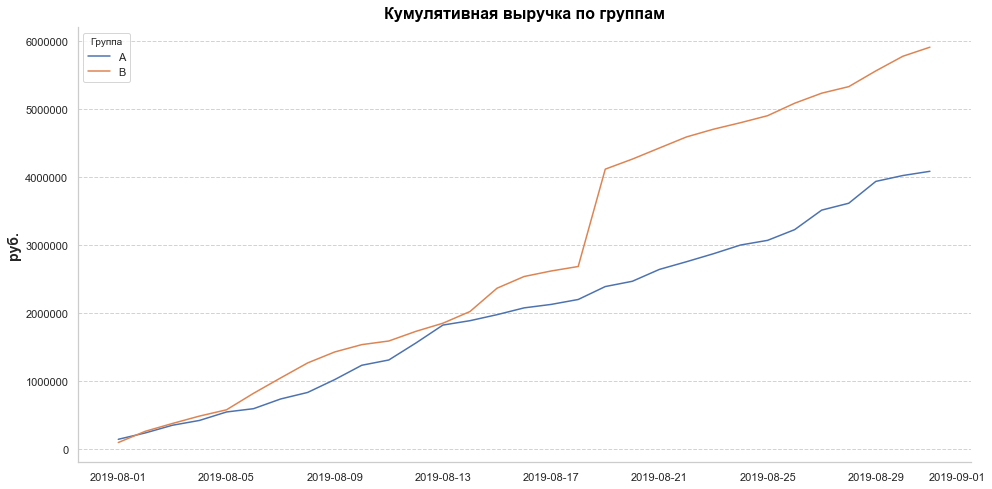

In [26]:
# график кумулятивной выручки по группам
plt.plot(data['date'], data['revenueCummulativeA'], label='A')
plt.plot(data['date'], data['revenueCummulativeB'], label='B')

# подписи данных
plt.title('Кумулятивная выручка по группам', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('руб.', **axis_font)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(
    title='Группа',
    loc='upper left')

plt.show()

Выручка по группе А почти равномерно увеличивается в течение всего теста.   
Выручка по группе В также увеличивается в течение всего теста, но в тренде есть резкий скачок между 2019/08/17 и 2019/08/21. Это похоже на рост числа заказов или на крупный заказ. Их необходимо проанализировать на дальнейших шагах.

#### Кумулятивный средний чек 

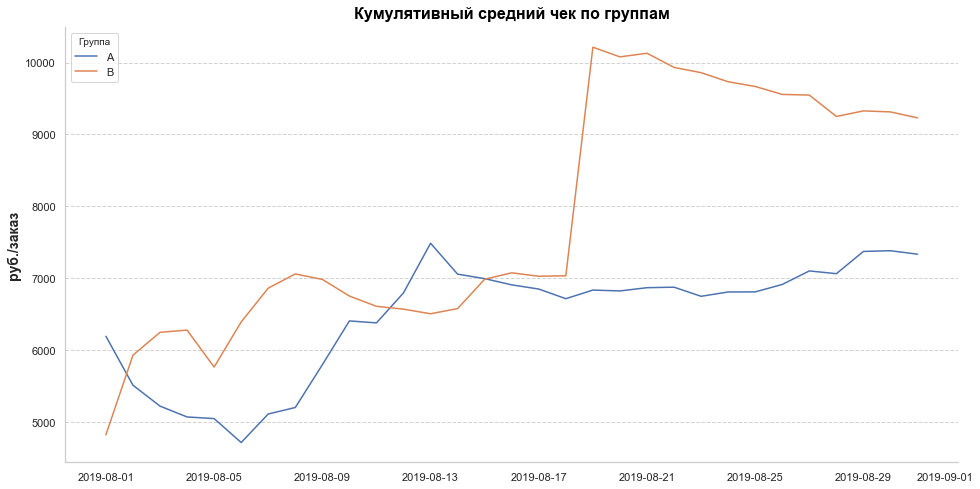

In [27]:
# график кумулятивного среднего чека
plt.plot(data['date'], data['order_avgA'], label='A')
plt.plot(data['date'], data['order_avgB'], label='B')

# подписи данных
plt.title('Кумулятивный средний чек по группам', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('руб./заказ', **axis_font)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(
    title='Группа',
    loc='upper left')

plt.show()

Тренд кумулятивного среднего чека по группе А в первой половине теста падает до 5000 руб., после чего резко растет (вероятно за счет крупных заказов) и продолжает плавный рост ближе к концу теста.   
В тренде кумулятивного среднего чека по группе B в первой половине теста попали крупные заказы (локальные горбы на графике). После половины теста в группу В попали крупные заказы (резкий всплеск на графике). Ближе к концу теста тренд по группе продолжает снижаться — приближаться к реальному среднему чеку после скачка.

#### Относительное изменение кумулятивного среднего чека группы B к группе A

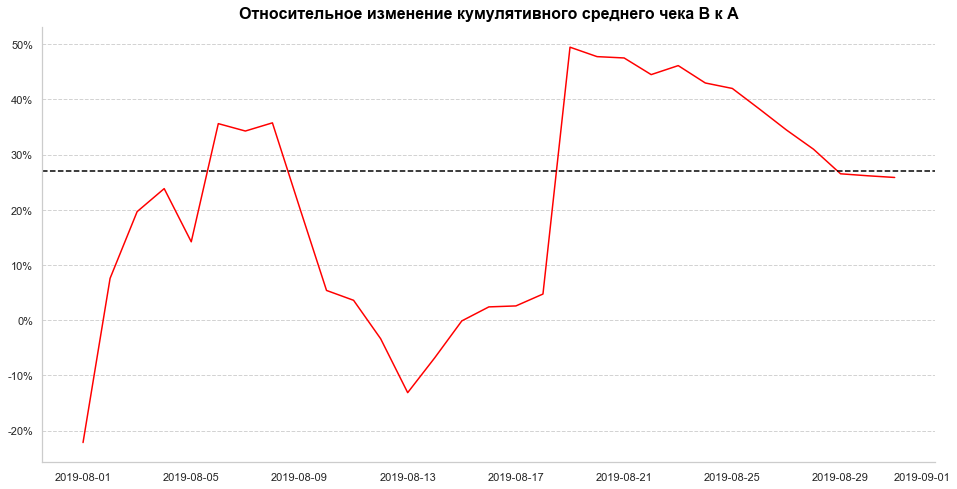

In [28]:
# график отношение средних чеков
plt.plot(data['date'], data['order_avgB'] / data['order_avgA'] - 1, color='red')

plt.axhline(y=0.27, color='black', linestyle='--')

# подписи данных
plt.title('Относительное изменение кумулятивного среднего чека В к А', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Тренд относительного изменения кумулятивного среднего чека группы B к группе A резко проваливается 2019/08/17, после чего резко растет между 2019/08/17 и 2019/08/2 из-за дорогих заказов, которые упомянуты ранее.

### Конверсия

#### Кумулятивная конверсия по группам

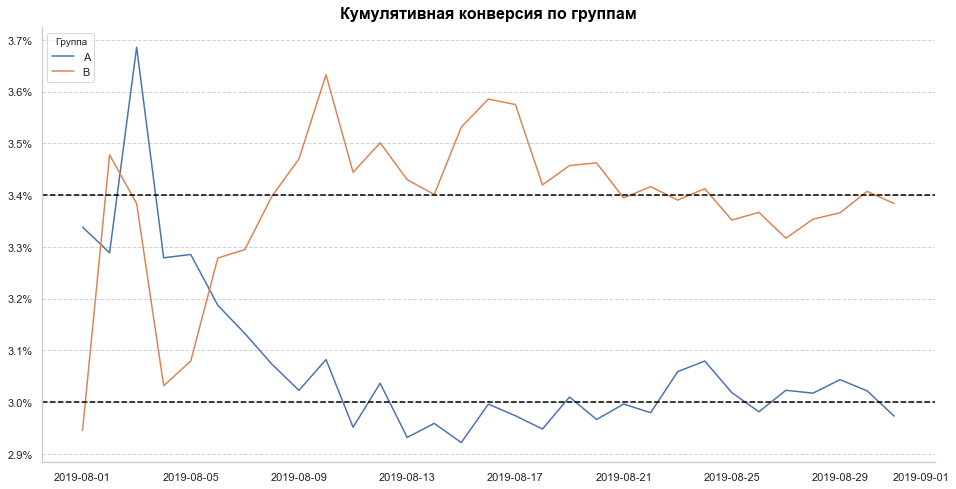

In [29]:
# график кумулятивной конверсии
plt.plot(data['date'], data['conversionCummulativeA'], label='A')
plt.plot(data['date'], data['conversionCummulativeB'], label='B')


plt.axhline(y=0.034, color='black', linestyle='--')
plt.axhline(y=0.03, color='black', linestyle='--')
# масштаб осей
#plt.axis(['2019-08-01', '2019-09-01', 0, 0.04])


# подписи данных
plt.title('Кумулятивная конверсия по группам', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)
plt.gca().set_yticklabels(['{:.1f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(
    title='Группа',
   loc='upper left')

plt.show()

Тренды кумулятивной конверсии по группам в начале теста колеблются. В первую неделю теста группа А показала лучший результат, чем В, которая локально провалилась. После половины теста графики стабилизировались около значений:
- А: 3,4%
- В: 3,0%

#### Относительное изменение кумулятивной конверсии группы B к группе A

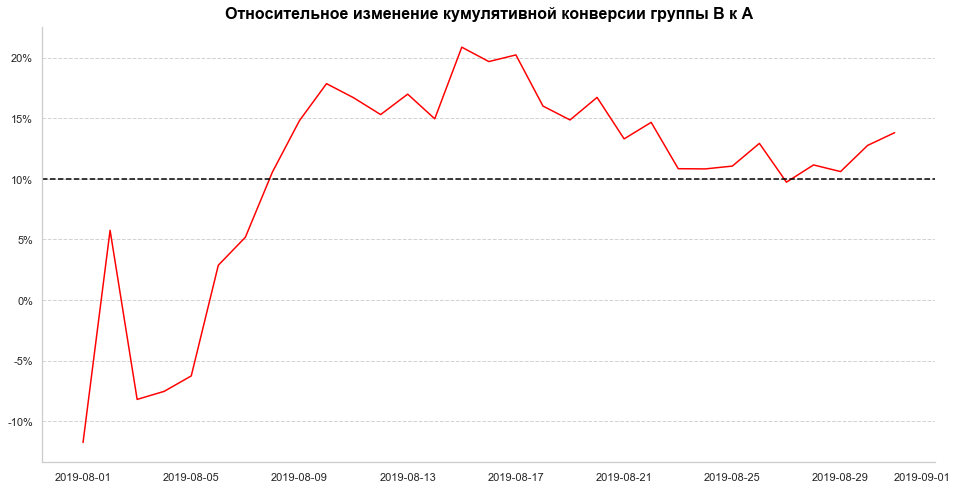

In [30]:
# график отношение средних чеков
plt.plot(data['date'], data['conversion_trend'], color='red')

plt.axhline(y=0.1, color='black', linestyle='--')

# подписи данных
plt.title('Относительное изменение кумулятивной конверсии группы В к А', **title_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Тренд относительного изменения кумулятивной конверсии группы B к группе A в начале теста отрицательный. Это произошло из-за локального роста по группе А, который наложился на локальный провал группы В, показанные на гарфике __кумулятивной конверсия по группам__. После половины теста тренд стабилизировался между 10 и 15%.

### Заказы

#### Количество заказов по пользователям

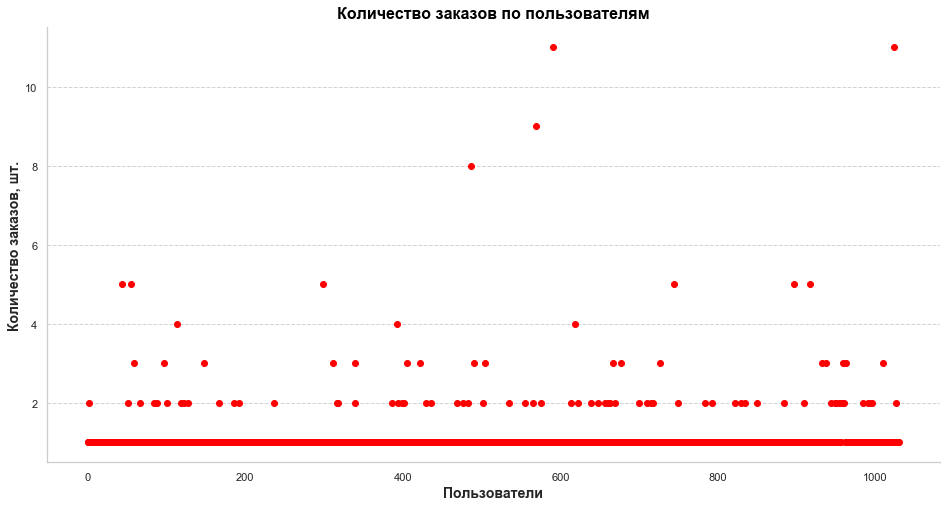

In [31]:
# количество заказов по пользователям
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'], color='red')

# подписи данных
plt.title('Количество заказов по пользователям', **title_font)
plt.xlabel('Пользователи', **axis_font)
plt.ylabel('Количество заказов, шт.', **axis_font)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Основная часть клиентов сделала только 1 заказ. Необходимо определить долю клиентов с 2-4 заказами. 

#### Граница аномальных пользователей с большим количеством заказов

In [32]:
# 95-й и 99-й перцентили количества заказов на пользователя
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% клиентов заказывали более двух раз.   
Не более 1% клиентов оформляли больше чем 4 заказов.   
Принимаем __2 заказа__ за нижнюю границу чтобы отсеять аномальных пользователей по количеству заказов.

In [33]:
# граница количества заказов аномальных пользователей
order_number_limit = 2

#### Стоимость заказов

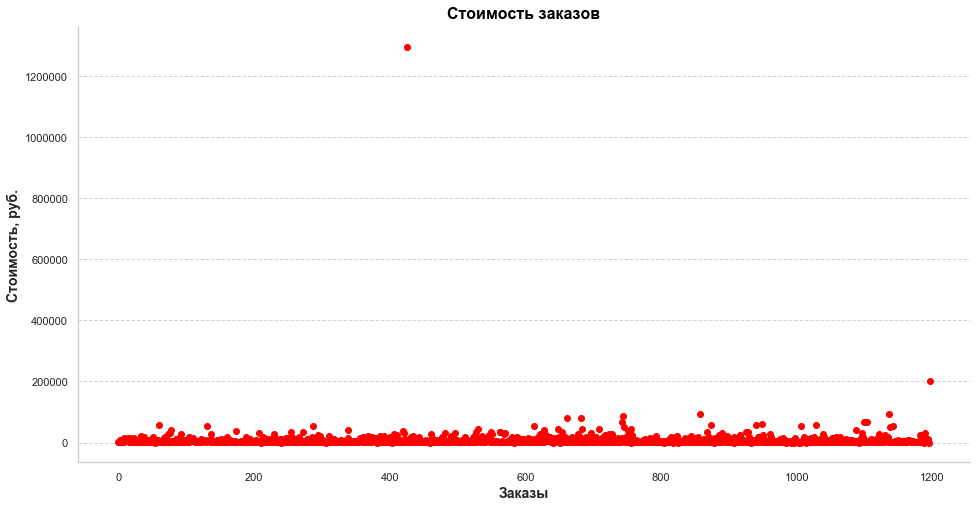

In [34]:
# стоимость заказов 
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color='red')

# подписи данных
plt.title('Стоимость заказов', **title_font)
plt.xlabel('Заказы', **axis_font)
plt.ylabel('Стоимость, руб.', **axis_font)

# границы графика и сетка
plt.grid(False)
plt.grid(
    color='lightgrey',
    which='major',
    axis='y',
    linestyle='--'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Основная часть заказов стоит до 20 000 руб. сделала только 1 заказ.   
Более дорогие заказы — единичны.   
Необходимо определить долю клиентов с дорогими заказами.

#### Граница стоимости аномальных заказов

In [35]:
# 95-й и 99-й перцентили стоимости заказов
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% заказов дороже 28 000 руб. и не более 1% дороже 58 233 рублей.   
С учетом того, что по графику основная часть заказов стоит до 20 000 руб., необходимо проверить 90-й перцентиль стоимости заказов.

In [36]:
# 90-й перцентиль стоимости заказов
print(np.percentile(orders['revenue'], [90]))

[18168.]


Принимаем __18 200 руб.__ за нижнюю границу чтобы отсеять аномальных пользователей по стоимости заказов.

In [37]:
# граница стоимости заказов аномальных пользователей
order_revenue_limit = 18200

### Очистка данных от аномальных клиентов

In [38]:
# выборка клиентов выше границы количества заказов
usersWithManyOrders = pd.concat([
    ordersByUsersA[ordersByUsersA['orders'] > order_number_limit]['userId'],
    ordersByUsersB[ordersByUsersB['orders'] > order_number_limit]['userId']
], axis = 0)

# выборка клиентов выше границы стоимости заказов
usersWithExpensiveOrders = orders[orders['revenue'] > order_revenue_limit]['visitorId']

# свод аномальных клиентов
abnormalUsers = pd.concat(
    [usersWithManyOrders, usersWithExpensiveOrders], 
    axis = 0
).drop_duplicates().sort_values()
abnormalUsers.head()

568     113298937
1099    148427295
461     154576532
18      199603092
928     204675465
dtype: int64

## Расчет статистической значимости
<a id = "stat"></a>

Для дальнейших расчетов принимаем уровень статистической значимости 0.05, так как это локальное маркетинговое исследование.

In [39]:
# критический уровень статистической значимости
alpha = .05 

___

В данных есть выбросы, которые нельзя игнорировать — они существенно влияют на результат при только двух выборках (А и В).   
Скорее всего распределение стоимостей заказов не нормально, но необходимо проверить взяты ли выборки из нормально распределённой генеральной совокупности:
- Если распределение нормально — проверять статистическую значимость увеличения доли заказов от посещений по сравнению средних двух совокупностей ЦПТ.
- Если распределение не нормально — применять непараметрический тест Уилкоксона-Манна-Уитни.

#### Проверка нормального распределения данных о продажах по критерию Шапиро-Уилка
- Нулевая гипотеза: распределение нормально.
- Альтернативная гипотеза: распределение не нормально.

In [40]:
# критический уровень статистической значимости
alpha = .05

# проверка нормального распределения
results = st.shapiro(orders['revenue'])
p_value = results[1]


print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение стоимостей не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу: распределение стоимостей нормально")

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение стоимостей не нормально


Распределение стоимостей покупок в выборке не нормально.    
__Далее необходимо применять непараметрический тест Уилкоксона-Манна-Уитни.__

### Статистическая значимость различий по «сырым» данным

In [41]:
# подготовка выборки к проверке критерием Манна-Уитни - заполнение нулями клиентов без заказаов
sampleA = pd.concat(
    [ordersByUsersA['orders'],
     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],
    axis=0)

sampleB = pd.concat(
    [ordersByUsersB['orders'],
     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],
    axis=0)

#### Конверсия

In [42]:
# относительный прирост конверсии группы В относительно группы А по сырым данным
conversion_relative = ((data['ordersPerDateB'].sum() / data['visitorsPerDateB'].sum()) / 
    (data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum()) - 1)

# статистическая значимость прироста конверсии группы В относительно группы А по сырым данным
p_value_conversion = st.mannwhitneyu(sampleA, sampleB)[1]

print('Относительный прирост конверсии группы В относительно группы А по «сырым» данным: {0:.1%}'.format(conversion_relative))
print('p-value: {0:.4f}'.format(p_value_conversion))

if (p_value_conversion < alpha):
    print('Есть статистическое различие. Изменение конверсии скорее возникло из-за нововведений на сайте.')
else:
    print('Нет статистического различия. Изменение конверсии могло возникнуть без учета нововведений на сайте.')

Относительный прирост конверсии группы В относительно группы А по «сырым» данным: 13.8%
p-value: 0.0084
Есть статистическое различие. Изменение конверсии скорее возникло из-за нововведений на сайте.


- Относительный прирост конверсии группы В к группе А: 13.8%.
- p-value меньше 0,05 — между группами есть статистическое различие в конверсии.

#### Средний чек

In [43]:
# относительный прирост среднего чека в группе В относительно группы А по сырым данным
order_avg_relative = (orders[orders['group']=='B']['revenue'].mean() / 
                      orders[orders['group']=='A']['revenue'].mean() - 1)

# статистическая значимость прироста среднего чека в группе В относительно группы А по сырым данным
p_value_order_avg_relative = st.mannwhitneyu(
    orders[orders['group']=='A']['revenue'],
    orders[orders['group']=='B']['revenue']
)[1]

print('Относительный прирост среднего чека в группе В относительно группы А \
по «сырым» данным: {0:.1%}'.format(order_avg_relative))
print('p-value: {0:.4f}'.format(p_value_order_avg_relative))

if (p_value_order_avg_relative < alpha):
    print('Есть статистическое различие. Изменение среднего чека скорее возникло из-за нововведений на сайте.')
else:
    print('Нет статистического различия. Изменение среднего чека могло возникнуть без учета нововведений на сайте.')

Относительный прирост среднего чека в группе В относительно группы А по «сырым» данным: 25.9%
p-value: 0.3646
Нет статистического различия. Изменение среднего чека могло возникнуть без учета нововведений на сайте.


- Относительный прирост среднего чека в группе В относительно группы А: 25.9%. 
- При этом, p-value больше 0,05 — по «сырым» данным между группами нет статистического различия в среднем чеку. Рост среднего чека мог произойти не из-за внедрения новой гипотезы.   
__Необходимо исключить влияние аномалий и проверить статистическую значимость.__

### Статистическая значимость различий по «очищенным» данным

In [44]:
# очистка от аномалий и подготовка выборки к проверке критерием Манна-Уитни
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],
    axis=0)

sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],
    axis=0)

#### Конверсия

In [45]:
# относительный прирост конверсии группы В относительно группы А по очищенным данным
conversion_relative_filtered = sampleBFiltered.mean() / sampleAFiltered.mean() - 1

# статистическая значимость прироста конверсии группы В относительно группы А по очищенным данным
p_value_conversion_filtered = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

print('Относительный прирост конверсии группы В относительно группы А \
по «очищенным» данным: {0:.1%}'.format(conversion_relative_filtered))
print('p-value: {0:.4f}'.format(p_value_conversion_filtered))

if (p_value_conversion_filtered < alpha):
    print('Есть статистическое различие. Изменение конверсии скорее возникло из-за нововведений на сайте.')
else:
    print('Нет статистического различия. Изменение конверсии могло возникнуть без учета нововведений на сайте.')

Относительный прирост конверсии группы В относительно группы А по «очищенным» данным: 17.2%
p-value: 0.0096
Есть статистическое различие. Изменение конверсии скорее возникло из-за нововведений на сайте.


- Относительный прирост конверсии группы В к группе А по «очищенным» данным 17.2 выше, чем по «сырым». Вероятно, исключенные покупатели много раз заходили на сайт перед покупкой и их исключение изменило показатели конверсии.
- p-value также меньше 0,05 — между группами есть статистическое различие в конверсии.

#### Средний чек

In [46]:
# относительный прирост среднего чека в группе В относительно группы А по очищенным данным
order_avg_relative_filtered = (orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() / 
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)

# статистическая значимость различия средних чеков после удаления аномальных пользователей
p_value_order_avg_relative_filtered = st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']
)[1]

print('Относительный прирост среднего чека в группе В относительно группы А \
по «очищенным» данным: {0:.1%}'.format(order_avg_relative_filtered))
print('p-value: {0:.4f}'.format(p_value_order_avg_relative_filtered))

if (p_value_order_avg_relative_filtered < alpha):
    print('Есть статистическое различие. Изменение среднего чека скорее возникло из-за нововведений на сайте.')
else:
    print('Нет статистического различия. Изменение среднего чека могло возникнуть без учета нововведений на сайте.')

Относительный прирост среднего чека в группе В относительно группы А по «очищенным» данным: -4.9%
p-value: 0.3095
Нет статистического различия. Изменение среднего чека могло возникнуть без учета нововведений на сайте.


- Без исключенных покупателей, результаты группы В оказываются хуже, чем у группы А. Вероятно, как раз за счет аномальных покупателей средний чек группы В оказался больше А, но стремился вниз к своему истинному значению.
- При этом, p-value больше 0,05 — по «очищенным» данным между группами нет статистического различия в среднем чеке.

## Решение по результатам теста
<a id = "conclusion"></a>

In [47]:
# общее количество посещений
visitors.groupby('group')['visitors'].sum().sum()

37652

- Согласно калькулятору, необходимый размер теста конверсии — 57000 посещений (https://www.optimizely.com/sample-size-calculator/?conversion=3&effect=10&significance=95)
- Общее количество посещений в тесте 37652.   
__Необходимо корректно выбирать размер теста при проведении последующих тестов.__

___

__Гипотезы:__   
- В общем плане
    - Гипотезы 7 и 0 остаются в тройке лидеров независимо от фреймворка ICE или RICE.
    - Гипотеза 7 имеет больший охват, чем гипотеза 0. Гипотеза 7 требует немного меньше трудозатрат, чем гипотеза 0.
    - Рекомендуется первой проверить гипотезу 7.
- В разрезе задания
    - В данном проекте далее будет проверятся конверсия и продажи. Это может говорить, что принята гипотеза, нацеленная на увеличение именно этих метрик, а не на охват и расширение базы клиентов (гипотезы 0 и 7).
    - Вероятно, что по логике задания была принята гипотеза 8: Запустить акцию, дающую скидку на товар в день рождения.

__А/В тест:__
- Выручка
    - Выручка по группам растет параллельно примерно до середины теста, после чего в группу В попадает аномальный заказ. С ним группа В опережает А по выручке на __ руб.
- Средний чек
    - Стоимость 90% заказов не превышает 18,2 тыс. руб. 
    - По сырым данным, средний чек по группам первую половину теста колеблется, после чего по группе А выравнивается около 7000 руб. По группе В после скачка до 10000 руб. за счет аномальной покупки в середине теста, он стремится вниз к своему истиному среднему.
    - График различия среднего чека колеблется. К концу теста нельзя сказать, что он установился около какго-то значения.
    - __По очищенным данным, средний чек группы В меньше на 5%, чем в группе А.__
    - __Нет статистически значимого различия по среднему чеку между группами как по сырым данным, так и по очищенным. Средний чек мог измениться без учета нововведений.__
- Конверсия
    - Тренды кумулятивной конверсии по группам в начале теста колеблются. После половины теста графики стабилизировались около значений:
        - А: 3,4%
        - В: 3,0% 
    - По различию конверсии между группами, результаты группы B лучше группы A. У гурппы В есть рост, который после половины теста фиксируется около среднего значения 10%.
    - Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.


__Рекомендации:__
- Остановить тест. 
- Зафиксировать:
    - Конверсия - успешный. В группе В посетители совершили больше покупок.
    - Средний чек - не успешный. В группе В посетители совершали более дешевые покупки. Но нет статистического различия на это от внедрения гипотезы 8: скидка на ДР.
- Перейти к проверке следующей гипотезы.
- При необходимости проверить гипотезу по среднему чеку текущий тест продолжать нельзя. Необходимо определить новые параметры и длительность теста и повторить его.